# Class Activation Maps in Radiographs - Images Obtained by Lung Localization Algorithm
***

### Installing and Importing Packages

In [3]:
!pip install lungs_segmentation
!pip install opencv-python==4.1.2.30

from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, multilabel_confusion_matrix
from sklearn.model_selection import train_test_split
from bbox_delimiters import bbox_utils
import matplotlib.pyplot as plt
from google.colab import drive 
import urllib.request as url
import seaborn as sn
import pandas as pd
import numpy as np
import random
import time
import cv2

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg19 import VGG19
import tensorflow as tf

### Downloading the CheXpert Dataset Images

In [ ]:
!cp -r /content/drive/MyDrive/datasets/chexpert-v10-small.zip /content/
!unzip /content/chexpert-v10-small.zip
!rm /content/chexpert-v10-small.zip

### Data pre-processing

In [5]:
image_size, batch_size = 256, 32
df = pd.read_csv('/content/CheXpert-v1.0-small/train.csv', delimiter = ',')

labels = ['Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Atelectasis', 
          'Pneumothorax', 'Pleural Effusion']

In [6]:
df = df[df['Frontal/Lateral'] == 'Frontal'].copy()
df.drop(labels = 'Frontal/Lateral', axis = 1, inplace = True)

df.drop(labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                  'Fracture', 'Support Devices'], axis = 1, inplace = True)

df = df[(df['AP/PA'] == 'AP') | (df['AP/PA'] == 'PA')].copy()
df.drop(labels = 'AP/PA', axis = 1, inplace = True)
 
df = df[(df['Age'] <= 80) | (df['Age'] >= 10)]
df.drop(labels = 'Age', axis = 1, inplace = True)

df.drop(labels=['Sex', 'Pneumonia', 'Pleural Other'], axis=1, inplace=True)

df.replace(to_replace = float('NaN'), value = 0.0, inplace = True)
df.replace(to_replace = -1.0, value = 0.0, inplace = True)

In [7]:
def count_values(dataframe, label):
  '''
  conta o número de casos positivos de uma classe no conjunto de dados

  Args:
    dataframe (pandas) --> dataframe do conjunto de dados
    label (str) --> nome da classe em análise 

  Returns:
    lenght_dataframe (int) --> número de casos positivos na classe em análise

  '''

  return len(dataframe[dataframe[label] == 1.0])

In [8]:
print('{}: {} Imagens'.format(labels[0], count_values(df, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(df, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(df, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(df, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(df, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(df, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(df, labels[6])))

Lung Opacity: 94207 Imagens
Lung Lesion: 7040 Imagens
Edema: 49674 Imagens
Consolidation: 12982 Imagens
Atelectasis: 29718 Imagens
Pneumothorax: 17693 Imagens
Pleural Effusion: 76894 Imagens


In [9]:
lung_opacity = df[(df[labels[0]] == 1.) & (df[labels[1]] != 1.) & 
                  (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & 
                  (df[labels[6]] != 1.)].index

lung_lesion = df[(df[labels[0]] != 1.) & (df[labels[1]] == 1.) & 
                 (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & 
                 (df[labels[6]] != 1.)].index

edema = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & 
           (df[labels[2]] == 1.) & (df[labels[3]] != 1.) &
           (df[labels[4]] != 1.) & (df[labels[5]] != 1.) &  
           (df[labels[6]] != 1.)].index

consolidation = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & 
                   (df[labels[2]] != 1.) & (df[labels[3]] == 1.) &
                   (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & (
                       df[labels[6]] != 1.)].index

atelectasis = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & 
                 (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] == 1.) & (df[labels[5]] != 1.) & 
                 (df[labels[6]] != 1.)].index

pneumothorax = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & 
                  (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] == 1.) & 
                  (df[labels[6]] != 1.)].index
  
pleural_effusion = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & 
                      (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                      (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & 
                      (df[labels[6]] == 1.)].index

In [10]:
print('Imagens com rótulos individuais:\n')
print('{}: {} Imagens'.format(labels[0], len(lung_opacity)))
print('{}: {} Imagens'.format(labels[1], len(lung_lesion)))
print('{}: {} Imagens'.format(labels[2], len(edema)))
print('{}: {} Imagens'.format(labels[3], len(consolidation)))
print('{}: {} Imagens'.format(labels[4], len(atelectasis)))
print('{}: {} Imagens'.format(labels[5], len(pneumothorax)))
print('{}: {} Imagens'.format(labels[6], len(pleural_effusion)))

Imagens com rótulos individuais:

Lung Opacity: 23005 Imagens
Lung Lesion: 1385 Imagens
Edema: 9728 Imagens
Consolidation: 2570 Imagens
Atelectasis: 5088 Imagens
Pneumothorax: 5177 Imagens
Pleural Effusion: 9214 Imagens


In [11]:
df_pure_multilabel = pd.concat((df.drop(lung_opacity), df.drop(lung_lesion), 
                                df.drop(edema), df.drop(consolidation),
                                df.drop(atelectasis), df.drop(pneumothorax), 
                                df.drop(pleural_effusion)))

In [12]:
print('Imagens que compartilham mais de um rótulo:\n')
print('{}: {} Imagens'.format(labels[0], count_values(df_pure_multilabel, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(df_pure_multilabel, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(df_pure_multilabel, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(df_pure_multilabel, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(df_pure_multilabel, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(df_pure_multilabel, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(df_pure_multilabel, labels[6])))

Imagens que compartilham mais de um rótulo:

Lung Opacity: 636444 Imagens
Lung Lesion: 47895 Imagens
Edema: 337990 Imagens
Consolidation: 88304 Imagens
Atelectasis: 202938 Imagens
Pneumothorax: 118674 Imagens
Pleural Effusion: 529044 Imagens


In [13]:
ts1 = df_pure_multilabel.sample(n = 7040, weights = labels[1], random_state = 42)
ts2 = df_pure_multilabel.drop(ts1.index).sample(n = 7040, weights = labels[3], random_state = 42)
ts3 = df_pure_multilabel.drop(pd.concat([ts1, ts2]).index).sample(n = 7040, weights = labels[5], random_state = 42)
ts4 = df_pure_multilabel.drop(pd.concat([ts1, ts2, ts3]).index).sample(n = 4000, weights = labels[2], random_state = 42)
ts5 = df_pure_multilabel.drop(pd.concat([ts1, ts2, ts3, ts4]).index).sample(n = 4000, weights = labels[4], random_state = 42)

df_more_balanced = pd.concat([ts1, ts2, ts3, ts4, ts5])

In [14]:
print('{}: {} Imagens'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 14445 Imagens
Lung Lesion: 7308 Imagens
Edema: 8223 Imagens
Consolidation: 8072 Imagens
Atelectasis: 7788 Imagens
Pneumothorax: 8566 Imagens
Pleural Effusion: 12939 Imagens


In [15]:
lung_opacity = df_more_balanced[(df_more_balanced[labels[0]] == 1.)]
lung_opacity = lung_opacity.sample(n = 8000, random_state = 42)
df_more_balanced.drop(lung_opacity.index, inplace = True)

In [16]:
print('{}: {} Imagens'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 5034 Imagens
Lung Lesion: 4133 Imagens
Edema: 5786 Imagens
Consolidation: 5954 Imagens
Atelectasis: 5645 Imagens
Pneumothorax: 5802 Imagens
Pleural Effusion: 8671 Imagens


In [17]:
pleural_effusion = df_more_balanced[(df_more_balanced[labels[6]] == 1.)]
pleural_effusion = pleural_effusion.sample(n = 2671, random_state = 42)
df_more_balanced.drop(pleural_effusion.index, inplace = True)

In [18]:
print('{}: {} Imagens'.format(labels[0], count_values(df_more_balanced, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(df_more_balanced, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(df_more_balanced, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(df_more_balanced, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(df_more_balanced, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(df_more_balanced, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(df_more_balanced, labels[6])))

Lung Opacity: 4145 Imagens
Lung Lesion: 3470 Imagens
Edema: 4646 Imagens
Consolidation: 4685 Imagens
Atelectasis: 4635 Imagens
Pneumothorax: 5146 Imagens
Pleural Effusion: 5405 Imagens


In [19]:
lung_opacity = df[(df[labels[0]] == 1.) & (df[labels[1]] != 1.) & 
                  (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & 
                  (df[labels[6]] != 1.)]

lung_lesion = df[(df[labels[0]] != 1.) & (df[labels[1]] == 1.) & 
                 (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & 
                 (df[labels[6]] != 1.)]

edema = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & 
           (df[labels[2]] == 1.) & (df[labels[3]] != 1.) &
           (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & 
           (df[labels[6]] != 1.)]

consolidation = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & 
                   (df[labels[2]] != 1.) & (df[labels[3]] == 1.) &
                   (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & 
                   (df[labels[6]] != 1.)]

atelectasis = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & 
                 (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                 (df[labels[4]] == 1.) & (df[labels[5]] != 1.) & 
                 (df[labels[6]] != 1.)]

pneumothorax = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & 
                  (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                  (df[labels[4]] != 1.) & (df[labels[5]] == 1.) & 
                  (df[labels[6]] != 1.)]
  
pleural_effusion = df[(df[labels[0]] != 1.) & (df[labels[1]] != 1.) & 
                      (df[labels[2]] != 1.) & (df[labels[3]] != 1.) &
                      (df[labels[4]] != 1.) & (df[labels[5]] != 1.) & 
                      (df[labels[6]] == 1.)]

In [20]:
final_df = pd.concat((df_more_balanced, lung_opacity.sample(n = 1855, random_state = 42), lung_lesion, 
                      edema.sample(n = 1354, random_state = 42), consolidation.sample(n = 1315, random_state = 42),
                      atelectasis.sample(n = 1364, random_state = 42), pneumothorax.sample(n = 854, random_state = 42),
                      pleural_effusion.sample(n = 594, random_state = 42)))

In [21]:
print('{}: {} Imagens'.format(labels[0], count_values(final_df, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(final_df, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(final_df, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(final_df, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(final_df, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(final_df, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(final_df, labels[6])))

Lung Opacity: 6000 Imagens
Lung Lesion: 4855 Imagens
Edema: 6000 Imagens
Consolidation: 6000 Imagens
Atelectasis: 5999 Imagens
Pneumothorax: 6000 Imagens
Pleural Effusion: 5999 Imagens


In [22]:
train_df, test_df = train_test_split(final_df, test_size = 0.1, random_state = 42, shuffle = True)
train_df, valid_df = train_test_split(train_df, test_size = 0.11111, random_state = 42, shuffle = True)

In [23]:
print('Imagens de Treinamento:\n')
print('{}: {} Imagens'.format(labels[0], count_values(train_df, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(train_df, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(train_df, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(train_df, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(train_df, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(train_df, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(train_df, labels[6])))

print('\nImagens de Teste:\n')
print('{}: {} Imagens'.format(labels[0], count_values(test_df, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(test_df, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(test_df, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(test_df, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(test_df, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(test_df, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(test_df, labels[6])))

print('\nImagens de Validação:\n')
print('{}: {} Imagens'.format(labels[0], count_values(valid_df, labels[0])))
print('{}: {} Imagens'.format(labels[1], count_values(valid_df, labels[1])))
print('{}: {} Imagens'.format(labels[2], count_values(valid_df, labels[2])))
print('{}: {} Imagens'.format(labels[3], count_values(valid_df, labels[3])))
print('{}: {} Imagens'.format(labels[4], count_values(valid_df, labels[4])))
print('{}: {} Imagens'.format(labels[5], count_values(valid_df, labels[5])))
print('{}: {} Imagens'.format(labels[6], count_values(valid_df, labels[6])))

Imagens de Treinamento:

Lung Opacity: 4803 Imagens
Lung Lesion: 3888 Imagens
Edema: 4832 Imagens
Consolidation: 4832 Imagens
Atelectasis: 4772 Imagens
Pneumothorax: 4757 Imagens
Pleural Effusion: 4772 Imagens

Imagens de Teste:

Lung Opacity: 567 Imagens
Lung Lesion: 488 Imagens
Edema: 574 Imagens
Consolidation: 601 Imagens
Atelectasis: 561 Imagens
Pneumothorax: 657 Imagens
Pleural Effusion: 621 Imagens

Imagens de Validação:

Lung Opacity: 630 Imagens
Lung Lesion: 479 Imagens
Edema: 594 Imagens
Consolidation: 567 Imagens
Atelectasis: 666 Imagens
Pneumothorax: 586 Imagens
Pleural Effusion: 606 Imagens


### Applying Lung Localization to Images

In [ ]:
train_path, val_path, test_path = list(train_df['Path']), list(valid_df['Path']), list(test_df['Path'])

!cp -r /content/drive/MyDrive/lung-localization/vgg/model_vgg5.zip /content/
!unzip /content/model_vgg5.zip
model_loc = tf.keras.models.load_model('/content/content/model_vgg5')

lung_localization = bbox_utils()

In [25]:
def make_localization(filename):
  '''
  realiza a localização pulmonar em imagens de radiografia

  Args:
    filename (str) --> localização do arquivo de imagem
  '''

  coordinates = lung_localization.make_localization_cnn(model = model_loc, path_file = filename)
  image_array = cv2.imread(filename = filename)
  crop_image = lung_localization.crop_image(image = image_array, list_coordinates = coordinates)
  lung_localization.save_img(image = crop_image, path_file = filename)

  return

In [27]:
_ = list(map(make_localization, test_path))

### Organizing the Data Generator

In [29]:
train_gen = ImageDataGenerator(rescale = 1./255., shear_range = 0.1, zoom_range = 0.15,
                               rotation_range = 5, width_shift_range = 0.1, height_shift_range = 0.05,
                               fill_mode='constant')

train_gen = train_gen.flow_from_dataframe(dataframe = train_df, directory = None,
                                          x_col = 'Path', y_col = labels, class_mode = 'raw',
                                          batch_size = batch_size, target_size = (image_size, image_size))

test_gen = ImageDataGenerator(rescale = 1./255.)

valid_gen = test_gen.flow_from_dataframe(dataframe = valid_df, directory = None, x_col = 'Path',
                                         y_col = labels, class_mode = 'raw', batch_size = batch_size,
                                         target_size = (image_size, image_size))

test_X, test_Y = next(test_gen.flow_from_dataframe(dataframe = test_df, directory = None, x_col = 'Path',
                                                   y_col = labels, class_mode = 'raw', batch_size = 2912,
                                                   target_size = (image_size, image_size)))

Found 20130 validated image filenames.
Found 2517 validated image filenames.
Found 2517 validated image filenames.


In [30]:
labels_editada = ['Opacidade', 'Lesão', 'Edema', 'Consolidação', 'Atelectasia',
                  'Pneumotórax', 'Efusão Pleural']

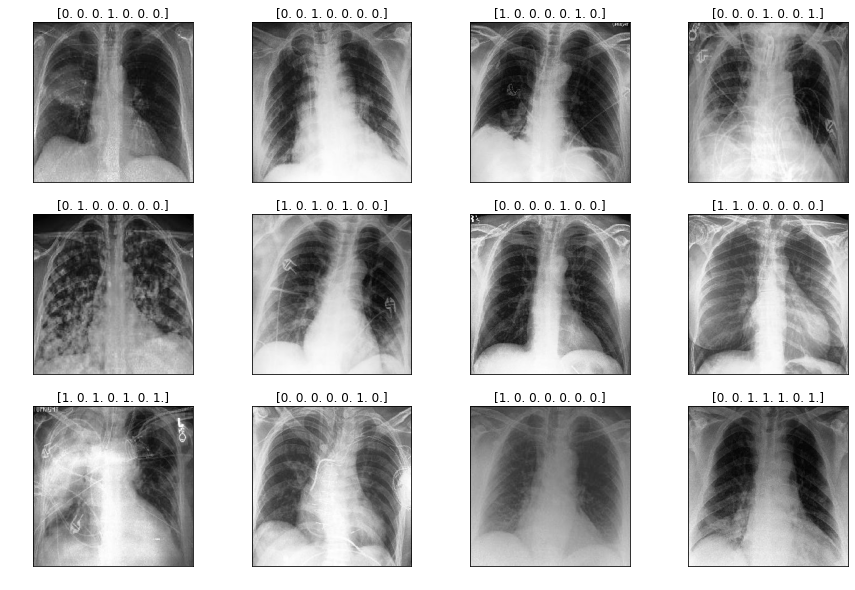

In [35]:
fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize = (15, 10))
count = 0
for i in range(0, 3):
  for j in range(0, 4):
    axs[i, j].set_title(str(test_Y[count]), color = 'black')
    axs[i, j].imshow(test_X[count])
    count +=1

In [ ]:
!cp -r /content/drive/MyDrive/lung-localization/classification-tests/ /content/
!unzip /content/classification-tests/densenet121_model.zip
!unzip /content/classification-tests/inceptionresnetv2_model.zip
!unzip /content/classification-tests/inceptionv3_model.zip
!unzip /content/classification-tests/mobilenetv2_model.zip
!unzip /content/classification-tests/resnet101v2_model.zip
!unzip /content/classification-tests/xception_model.zip

In [80]:
import tensorflow as tf

densenet_model = tf.keras.models.load_model('/content/content/densenet121_model')

In [42]:
from skimage.transform import resize
import matplotlib.cm as cm
import tensorflow as tf
from copy import copy
import numpy as np

def copy_model(model):
  '''
  creates a copy of the model made by tensorflow
  
  Args:
    model (model tensorflow) --> compiled model architecture

  Returns:
    copy_model (model tensorflow) --> copy of compiled model architecture
  '''

  return copy(model)

def predicted_best_class(img_array, model):
  '''
  returns the index of the class predicted by the model
  
  Args:
    img_array (array) --> array of the image to be predicted by the model
    model (model tensorflow) --> model trained with tensorflow
  
  Returns:
    argmax (int) --> maximum argument index of the predicted class
  '''

  return np.argmax(model.predict(img_array))

def get_img_array(img_path, target_size):
  '''
  returns an image array in standard tensorflow input format

  Args:
    img_path (str) --> file location where the image is saved
    target_size (list) --> image dimension to add to array

  Returns:
    img_array (array) --> image in array format
  '''
    
  try: 
    img = tf.keras.preprocessing.image.load_img(path = img_path, target_size = target_size)
  except: 
    img = img_path

  img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.

  return np.expand_dims(a = img_array, axis = 0)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None, 
                         auto_index = True):
  '''
  build a gradcam activation map
  
  Args:
    img_array (array) --> reference image for building the activation map
    model (model tensorflow) --> trained tensorflow model
    last_conv_layer_name (str) --> name of the last convolution layer of the model
    pred_index (int) --> target class index
    auto_index (bool) --> if true, use the best class predicted by the model

  Returns:
    gradcam_map (array) --> activation map made with gradcam algorithm
  '''
  
  if auto_index:
    pred_index = predicted_best_class(img_array = img_array, model = model)
  input = [model.inputs]
  output = [model.get_layer(last_conv_layer_name).output, model.output]
  grad_model = tf.keras.models.Model(inputs = input, outputs = output)

  with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model(img_array)
    if pred_index is None:
      pred_index = tf.argmax(preds[0])
    class_channel = preds[:, pred_index]

  grads = tape.gradient(class_channel, last_conv_layer_output)
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))
  last_conv_layer_output = last_conv_layer_output[0]
  heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
    
  return (tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)).numpy()

def resize_gradcam(img_array, heatmap):
  '''
  resize grad cam class activation map to original image dimensions

  Args:
    img_array (array) --> array of the original reference image
    heatmap (array) --> built activation map array

  Returns:
    heatmap_resized (array) --> activation map with the same dimensions as the 
    original image
  '''
   
  heatmap = np.uint8(255 * heatmap)
  jet_colors = cm.get_cmap("jet")(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    
  return tf.keras.preprocessing.image.img_to_array(jet_heatmap)
    
def get_grad_cam(img_array, target_size, last_conv_layer_name, copy_model, 
                 alpha = 0.9, pred_index = None, auto_index = True):
  '''
    builds class activation map using gradcam algorithm

    Args:
      img_array (array) --> array of the original reference image
      target_size (list) --> image dimension to add to array
      last_conv_layer_name (str) --> name of the last convolution layer of the model
      copy_model (model tensorflow) --> copy of compiled model architecture
      alpha (float) --> multiplicative factor of visualization of the activation map 
      superimposed on the image
      pred_index (int) --> target class index
      auto_index (bool) --> if true, use the best class predicted by the model
      
    Returns:
      gradcam_image (array) --> gradcam activation map
      overlap_image (array) --> gradcam activation map overlaid on image
  '''

  copy_model.layers[-1].activation = None
  heatmap = make_gradcam_heatmap(img_array = img_array, model = copy_model, 
                                 last_conv_layer_name = last_conv_layer_name)
    
  gradcam_image = resize_gradcam(img_array = img_array[0], heatmap = heatmap) / 255.
  overlap_image = img_array[0] + gradcam_image * alpha

  return gradcam_image / np.max(gradcam_image), overlap_image / np.max(overlap_image)

@tf.custom_gradient
def guidedRelu(x):
  '''
  activation function based on the backpropagation gradient

  Args:
    x (float) --> activation function input data
  Returns:
    x_activation (float) --> x output with relu activation function
    x_grad (float) --> gradient x calculation
  '''

  def grad(dy):

    return tf.cast(dy > 0, "float32") * tf.cast(x > 0, "float32") * dy

  return tf.nn.relu(x), grad

def get_grads(img_array, target_size, model, last_conv_layer_name):
  '''
  get the analysis image gradients

  Args:
    img_array (array) --> array of the original reference image
    target_size (list) --> image dimension to add to array
    model (tensorflow model) --> trained tensorflow model
    last_conv_layer_name (str) --> name of the last convolution layer of the model
    
  Returns:
    tape_gradients (tensor image) --> scaled gradients in the analysis image
    ouputs (tensor list) --> scaled gradients in the last convolution layer
  '''

  input = [model.inputs]
  output = [model.get_layer(last_conv_layer_name).output]
  gb_model = tf.keras.models.Model(inputs = input, outputs = output)
  layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer, 'activation')]

  for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu: layer.activation = guidedRelu

  with tf.GradientTape() as tape:
    inputs = tf.cast(img_array, tf.float32)
    tape.watch(inputs)
    outputs = gb_model(inputs)[0]
    
  return tape.gradient(outputs, inputs)[0], outputs

def guided_backpropagation(img_array, target_size, model, last_conv_layer_name):
  '''
  generates a salience map based on the guided backpropagatrion algorithm

  Args:
    img_array (array) --> array of the original reference image
    target_size (list) --> image dimension to add to array
    model (tensorflow model) --> trained tensorflow model
    last_conv_layer_name (str) --> name of the last convolution layer of the model
    
  Returns:
    guided_gb (array) --> salience map generated in the dimensions of the original image
  '''

  grads, _ = get_grads(img_array = img_array, target_size = target_size, 
                       model = model, last_conv_layer_name = last_conv_layer_name)

  guided_back_prop = grads
  guided_gb = np.dstack((guided_back_prop[:, :, 0], 
                         guided_back_prop[:, :, 1],
                         guided_back_prop[:, :, 2]))       
  guided_gb -= np.min(guided_gb)
  guided_gb /= guided_gb.max()

  return (guided_gb) / np.max(guided_gb)

def guided_grad_cam(img_array, target_size, last_conv_layer_name, model, copy_model, 
                    alpha = 0.9, pred_index = None, auto_index = True):
  '''
  generates a salience map based on the guided grad cam algorithm

  Args:
    img_array (array) --> array of the original reference image
    target_size (list) --> image dimension to add to array
    last_conv_layer_name (str) --> name of the last convolution layer of the model
    model (tensorflow model) --> trained tensorflow model
    copy_model (tensorflow model) --> copy of compiled model architecture
    alpha (float) --> multiplicative factor of visualization of the activation map 
    superimposed on the image
    pred_index (int) --> target class index
    auto_index (bool) --> if true, use the best class predicted by the model
    
  Returns:
    guided_gc (array) --> salience map generated in the dimensions of the original image
  '''

  grad_cam, _ = get_grad_cam(img_array = img_array, target_size = target_size, 
                             last_conv_layer_name = last_conv_layer_name, 
                             copy_model = copy_model, alpha = alpha)
  guided_back_prop, _ = get_grads(img_array = img_array, target_size = target_size, 
                               model = model, last_conv_layer_name = last_conv_layer_name)

  guided_cam = cv2.cvtColor(grad_cam, cv2.COLOR_RGB2GRAY)
  guided_cam = np.maximum(guided_cam, 0.5)
  guided_cam = guided_cam / np.max(guided_cam) 
  guided_gc = np.dstack((guided_back_prop[:, :, 0] * guided_cam, 
                         guided_back_prop[:, :, 1] * guided_cam,
                         guided_back_prop[:, :, 2] * guided_cam))
  
  guided_gc = np.maximum(guided_gc, 0)

  return (guided_gc) / np.max(guided_gc)

In [73]:
def image_patches(img_array, patch_size, channels):
  '''
  separate images by patches
  
  Args:
    img_array (array) --> array of the original reference image
    patch_size (int) --> size of an individual patch
    channels (int) --> number of channels in the image
  
  Returns:
    img_patches (array) --> separate image in several patches
  '''

  patches = tf.image.extract_patches(
    images = img_array, sizes = [1, patch_size, patch_size, 1],
    strides = [1, patch_size, patch_size, 1], rates = [1, 1, 1, 1], 
    padding = 'VALID')
  
  patch_dims = patches.shape[-1]
  patches = tf.reshape(tensor = patches, shape = [1, -1, patch_dims])

  return np.resize(patches[0], (patches.shape[1], patch_size, patch_size, channels))

def reconstructed_image(patches, patches_dims):
  '''
  rebuild the image from your patches

  Args:
    patches (array) -->image separated by patches
    patchs_dims (list) -->list containing (number of patches vertically, 
    number of patches horizontally)
  
  Returns:
    reconstructed_image (array) --> image reconstructed by patches
  '''

  count  = 0
  for i in range(0, patches_dims[0]):
    for j in range(0, patches_dims[1]):

      if j == 0:
        reconstruction_h = patches[count]
      elif j != 0:
        reconstruction_h = np.hstack((reconstruction_h, patches[count]))

      count += 1
    
    if i == 0:
      reconstruction_v = reconstruction_h 
    elif i != 0:
      reconstruction_v = np.vstack((reconstruction_v, reconstruction_h))
  
  return reconstruction_v

def make_occlusion(patches, patches_dims, val_occlusion = 128):
  '''
  algorithm that performs occlusion on image patches

  Args:
    patches (array) -->image separated by patches
    patchs_dims (list) -->list containing (number of patches vertically, 
    number of patches horizontally)
    val_occlusion (float) --> occlusion pixel value

  Returns:
    samples_images (array) --> occluded image samples
  '''

  images = list()
  occlusion_patch = np.ones(patches[0].shape) * val_occlusion

  for i in range(0, len(patches)):
    copy_patches = np.array(patches)
    copy_patches[i] = occlusion_patch 
    images.append(reconstructed_image(patches = copy_patches, patches_dims = patches_dims))
  
  return np.array(images)

def occlusion_prediction(img_array, patch_size, channels, patches_dims, model):
  '''
  predicts the image using the occlusion algorithm

  Args:
    img_array (array) --> array of the original reference image
    patch_size (int) --> size of an individual patch
    channels (int) --> number of channels in the image
    patchs_dims (list) -->list containing (number of patches vertically, 
    number of patches horizontally)
    model (tensorflow model) --> trained tensorflow model

  Returns:
    image_occlusion (array) --> predicted image occlusions
  '''
  pat = image_patches(img_array = img_array, patch_size = patch_size, channels = channels)
  imgs = make_occlusion(patches = pat, patches_dims = patches_dims, 
                        val_occlusion = np.max(img_array))
  predict_max = np.argmax(model.predict(img_array))

  predictions = list()
  for img in imgs:
    predictions.append(model.predict(tf.expand_dims(img, axis = 0)))

  image_occlusion = np.zeros((128, 128, 3))
  mean_value = np.mean(np.array(predictions)[:,0][:, predict_max])
  predictions = np.array(predictions)[:,0]

  for index, predict in enumerate(predictions):
    if predict[predict_max] > mean_value:
      pat[index] = np.zeros(pat[index].shape)

  image_occlusion = reconstructed_image(patches = pat, patches_dims = (4, 4))

  return image_occlusion / np.max(image_occlusion)

In [ ]:
densenet_copy = copy_model(densenet_model)


In [ ]:
guided_grad_cam()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


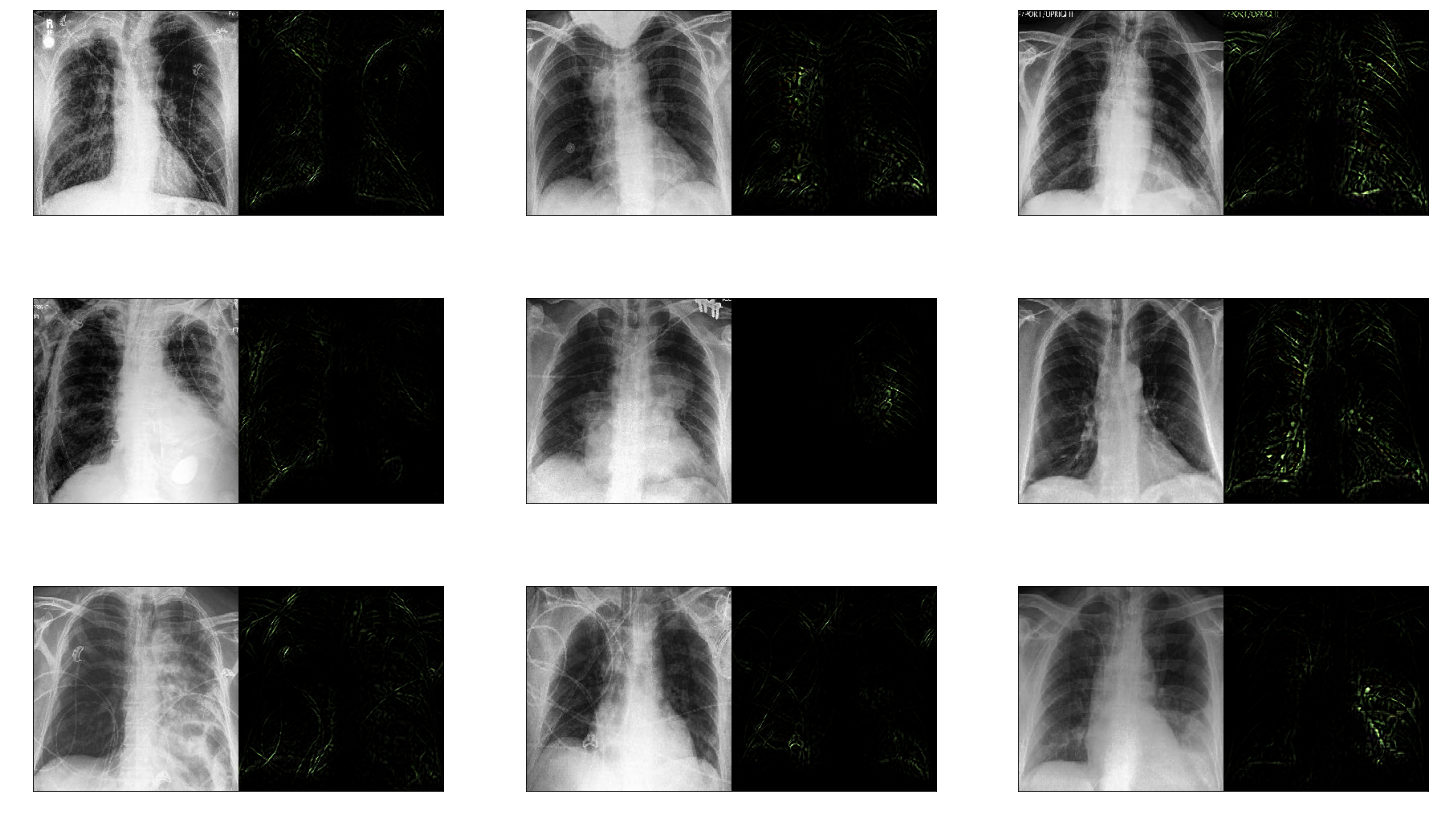

In [59]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (25, 15))
for i in range(0, 3):
  for j in range(0, 3):
    count = random.randrange(0, len(test_X))
    img_b = guided_grad_cam(img_array = tf.expand_dims(test_X[count], 0), target_size = (256, 256), 
                         last_conv_layer_name = 'conv5_block16_2_conv', model = densenet_model,
                         copy_model = densenet_copy) * 2
    img_concat = np.concatenate((test_X[count], img_b), axis = 1)
    axs[i][j].imshow(img_concat, vmin = np.min(img_concat), 
                     vmax = np.max(img_concat))

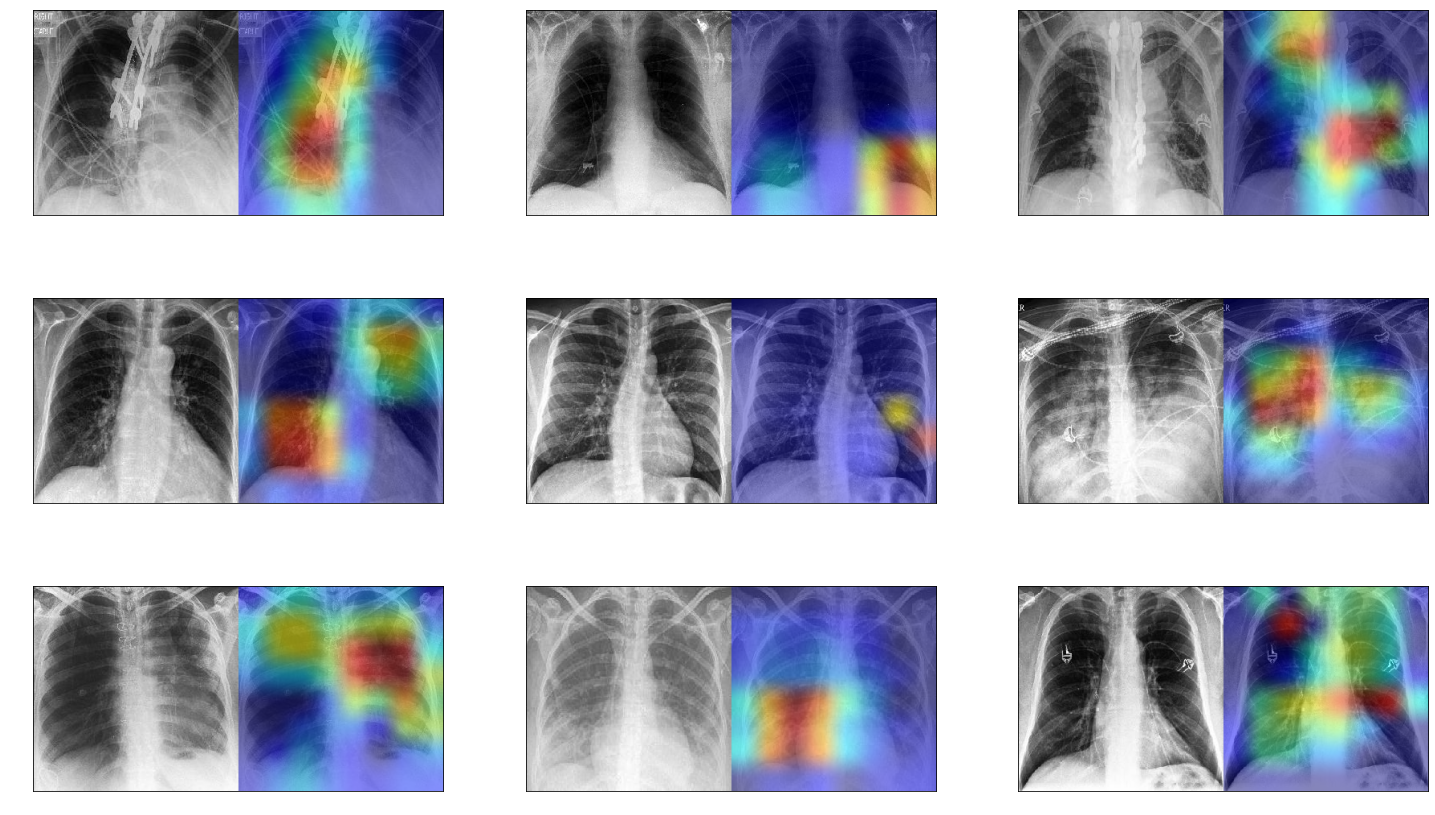

In [67]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (25, 15))
for i in range(0, 3):
  for j in range(0, 3):
    count = random.randrange(0, len(test_X))
    _, img_b = get_grad_cam(img_array = tf.expand_dims(test_X[count], 0), target_size = (256, 256), 
                            last_conv_layer_name = 'conv5_block16_2_conv', 
                            copy_model = densenet_copy)
    img_concat = np.concatenate((test_X[count], img_b), axis = 1)
    axs[i][j].imshow(img_concat, vmin = np.min(img_concat), 
                     vmax = np.max(img_concat))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


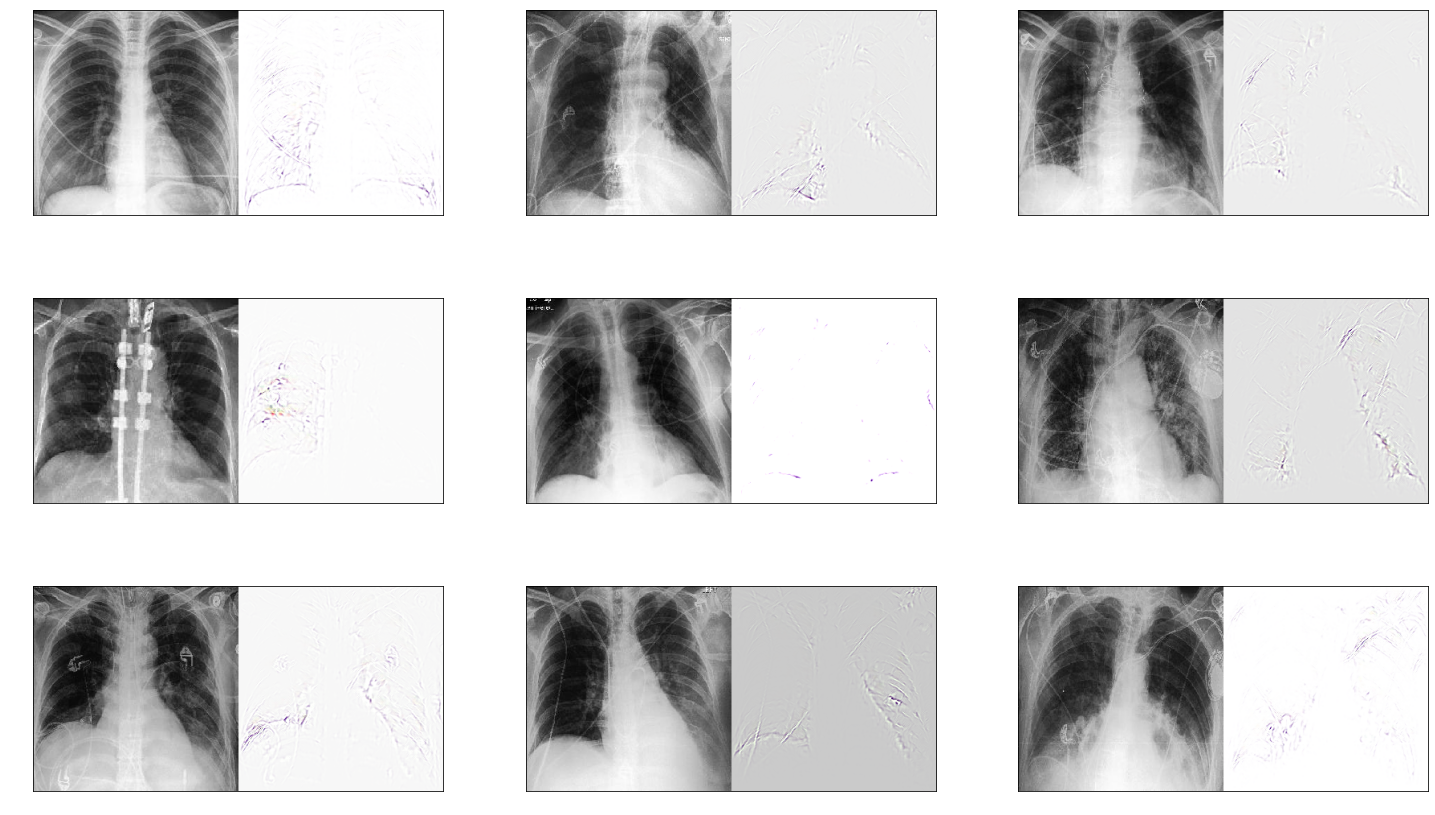

In [72]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (25, 15))
for i in range(0, 3):
  for j in range(0, 3):
    count = random.randrange(0, len(test_X))
    img_b = guided_backpropagation(img_array = tf.expand_dims(test_X[count], 0), 
                                   target_size = (256, 256), model = densenet_model,
                                   last_conv_layer_name = 'conv5_block16_2_conv') * 2
    img_concat = np.concatenate((test_X[count], img_b), axis = 1)
    axs[i][j].imshow(img_concat, vmin = np.min(img_concat), 
                     vmax = np.max(img_concat))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


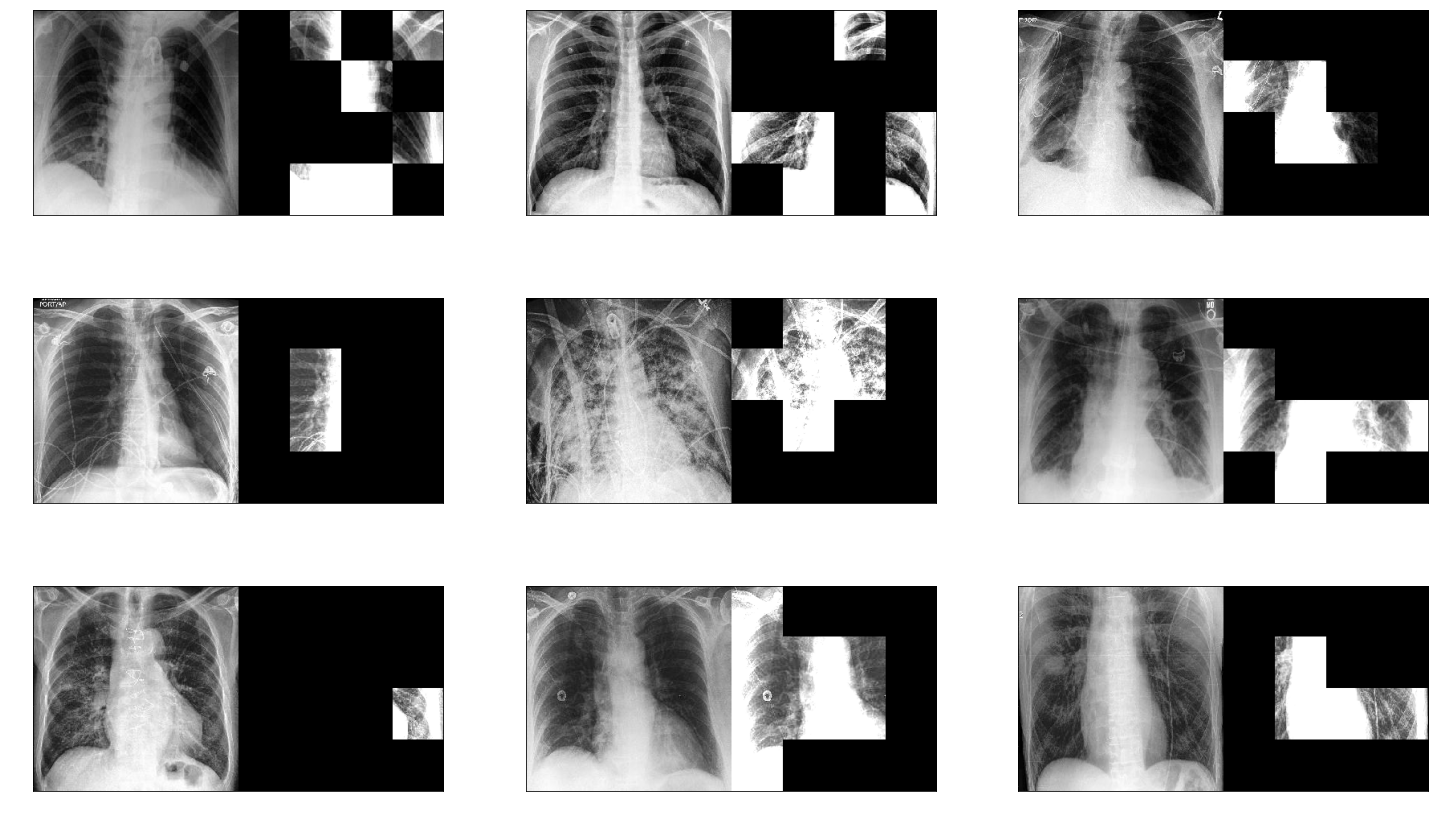

In [75]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (25, 15))
for i in range(0, 3):
  for j in range(0, 3):
    count = random.randrange(0, len(test_X))
    img_b = occlusion_prediction(img_array = tf.expand_dims(test_X[count], 0),
                                 patch_size = 64, channels = 3, patches_dims = (4,4),  
                                 model = densenet_model) * 2
    img_concat = np.concatenate((test_X[count], img_b), axis = 1)
    axs[i][j].imshow(img_concat, vmin = np.min(img_concat), 
                     vmax = np.max(img_concat))

In [ ]:
val_X, val_Y = next(valid_gen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


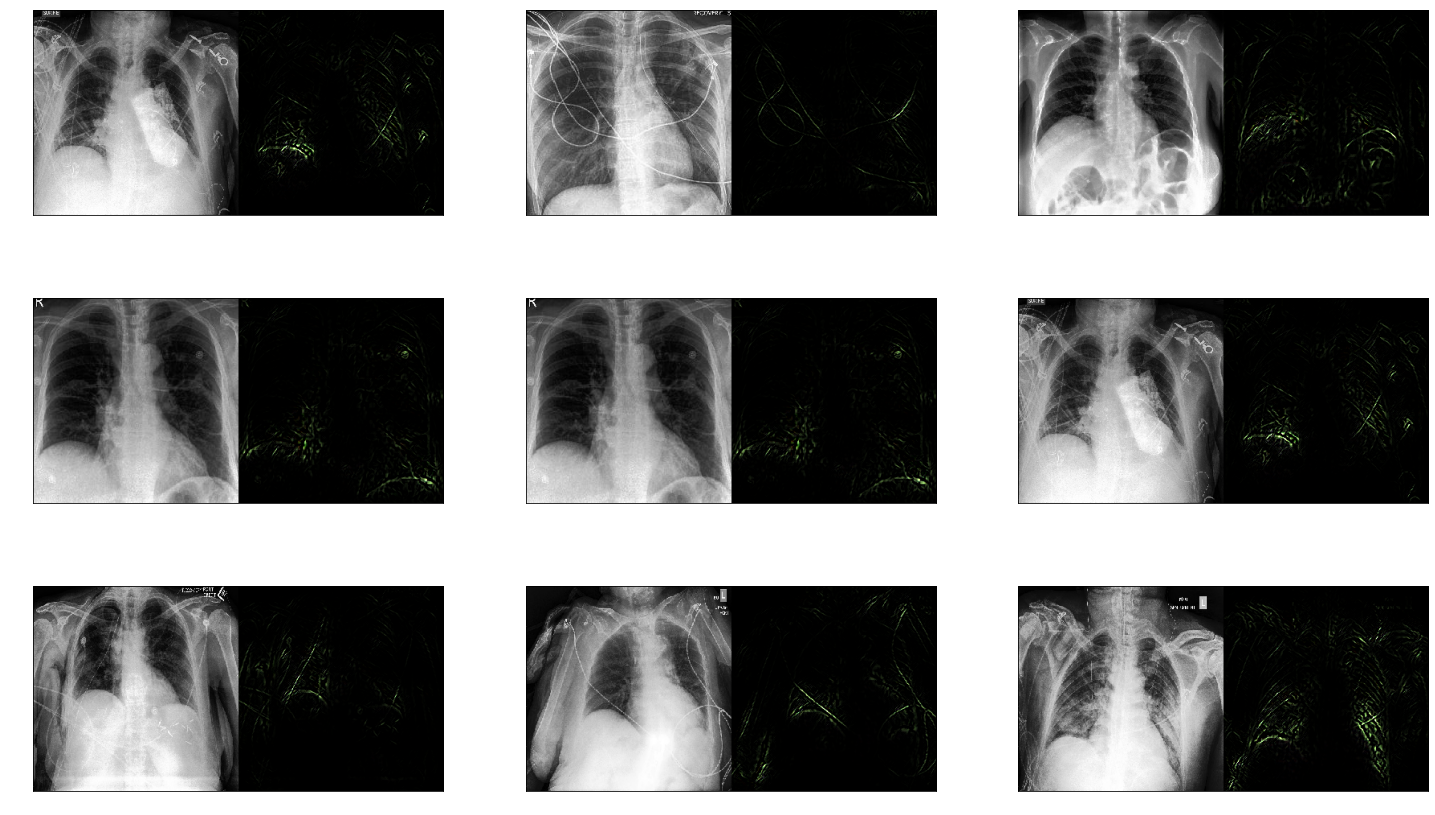

In [94]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (25, 15))
for i in range(0, 3):
  for j in range(0, 3):
    count = random.randrange(0, len(val_X))
    img_b = guided_grad_cam(img_array = tf.expand_dims(val_X[count], 0), target_size = (256, 256), 
                         last_conv_layer_name = 'conv5_block16_2_conv', model = densenet_model,
                         copy_model = densenet_copy) * 2
    img_concat = np.concatenate((val_X[count], img_b), axis = 1)
    axs[i][j].imshow(img_concat, vmin = np.min(img_concat), 
                     vmax = np.max(img_concat))

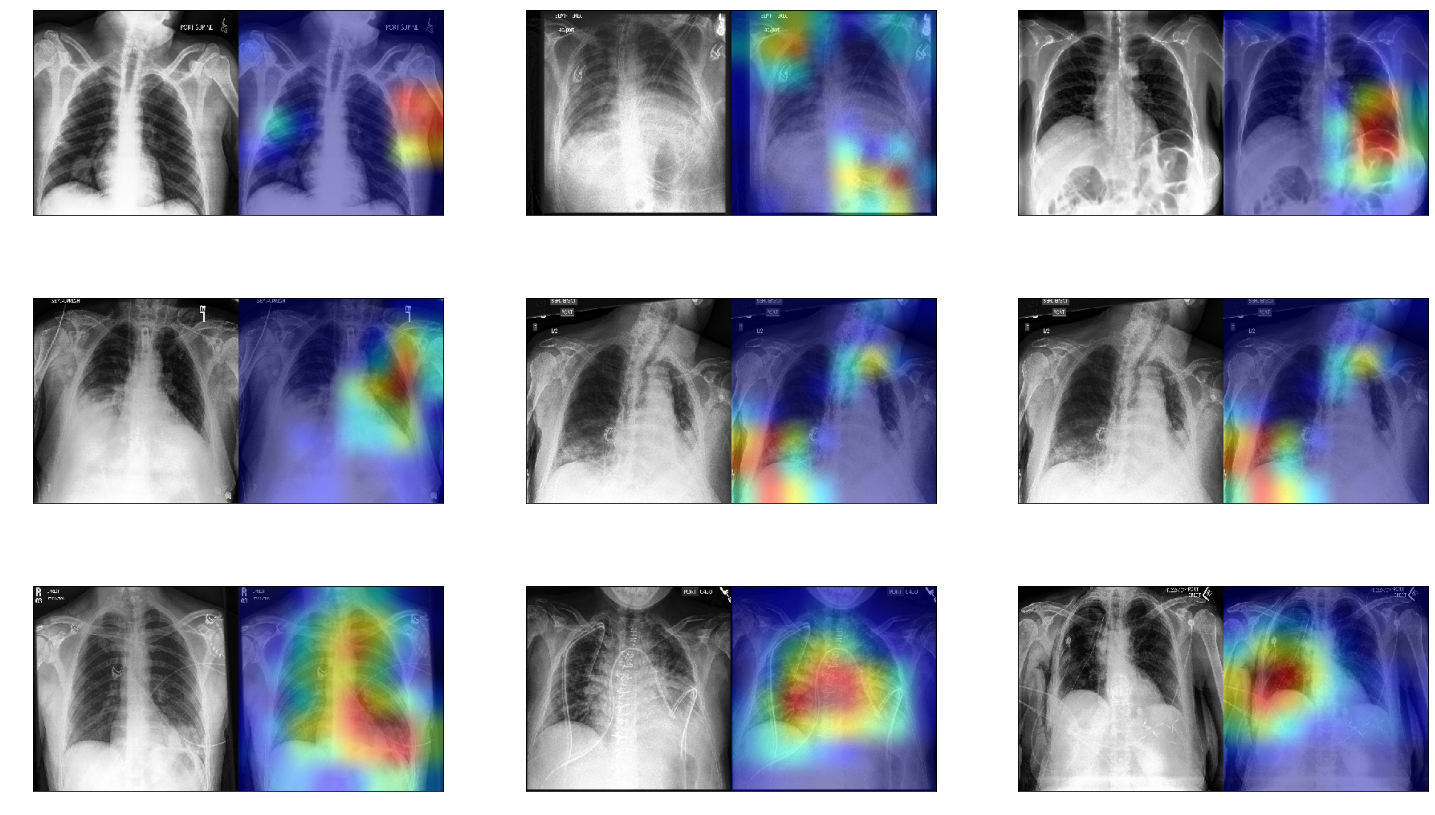

In [96]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (25, 15))
for i in range(0, 3):
  for j in range(0, 3):
    count = random.randrange(0, len(val_X))
    _, img_b = get_grad_cam(img_array = tf.expand_dims(val_X[count], 0), target_size = (256, 256), 
                            last_conv_layer_name = 'conv5_block16_2_conv', 
                            copy_model = densenet_copy)
    img_concat = np.concatenate((val_X[count], img_b), axis = 1)
    axs[i][j].imshow(img_concat, vmin = np.min(img_concat), 
                     vmax = np.max(img_concat))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


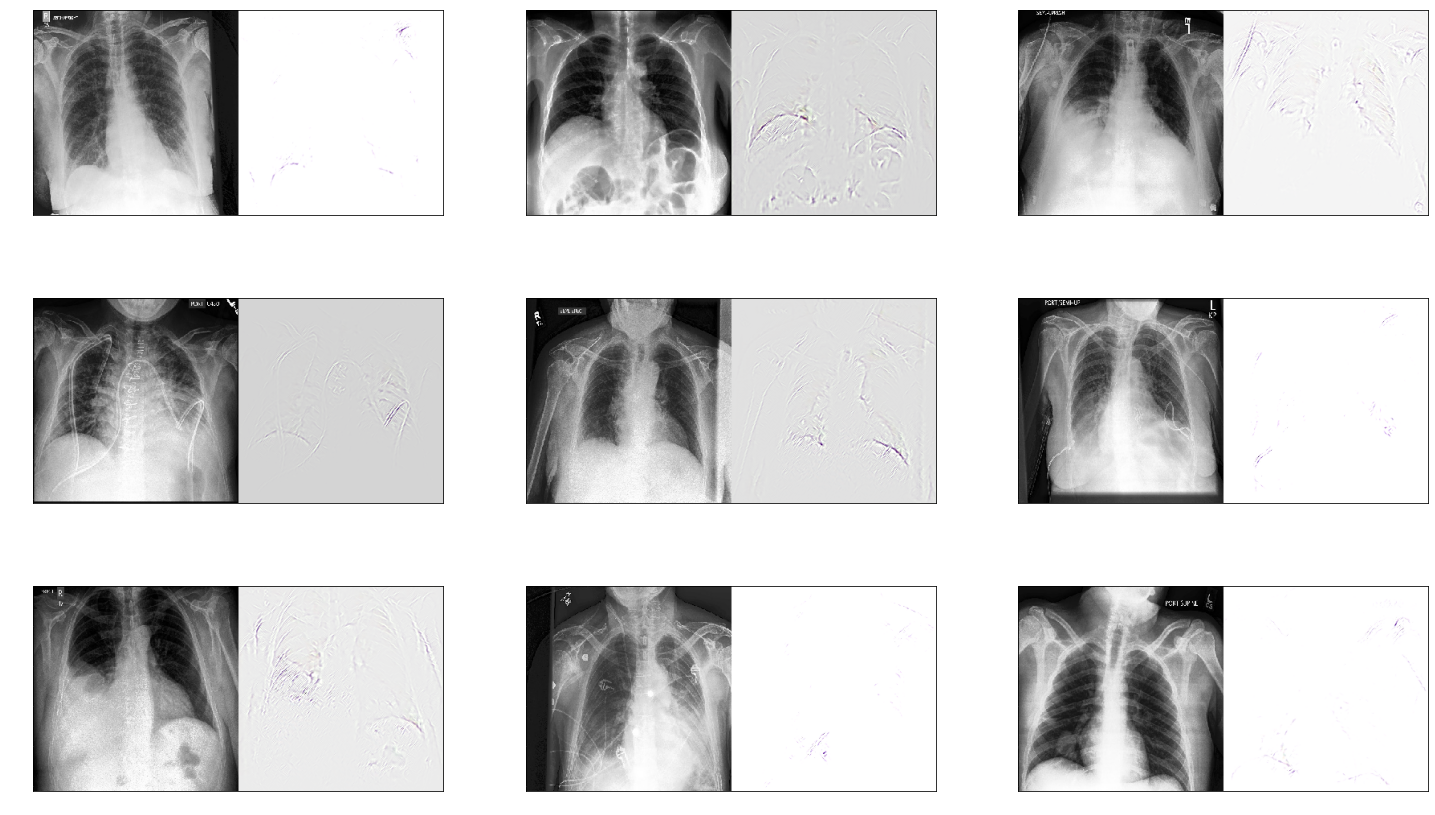

In [97]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (25, 15))
for i in range(0, 3):
  for j in range(0, 3):
    count = random.randrange(0, len(val_X))
    img_b = guided_backpropagation(img_array = tf.expand_dims(val_X[count], 0), 
                                   target_size = (256, 256), model = densenet_model,
                                   last_conv_layer_name = 'conv5_block16_2_conv') * 2
    img_concat = np.concatenate((val_X[count], img_b), axis = 1)
    axs[i][j].imshow(img_concat, vmin = np.min(img_concat), 
                     vmax = np.max(img_concat))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


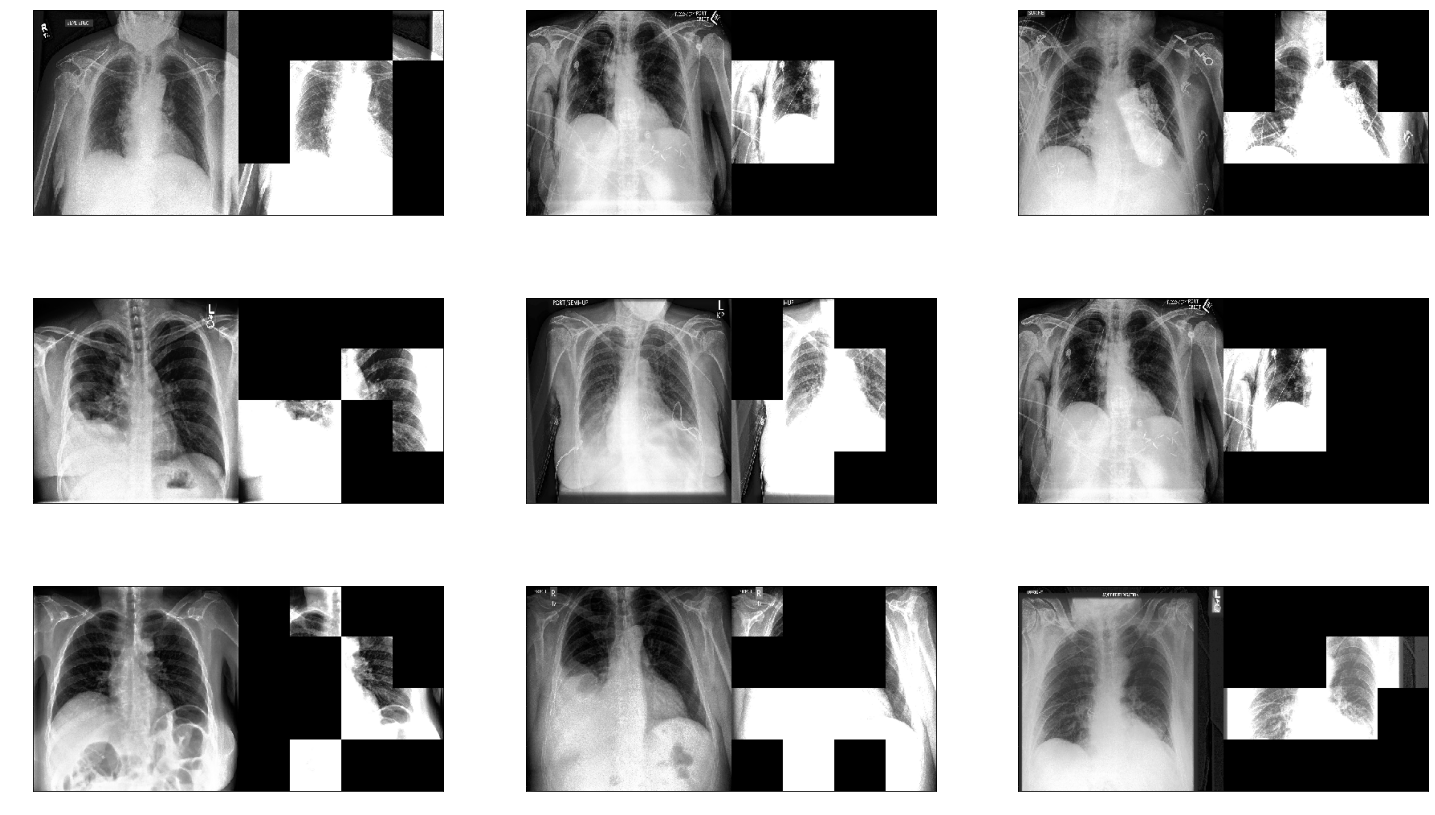

In [100]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (25, 15))
for i in range(0, 3):
  for j in range(0, 3):
    count = random.randrange(0, len(val_X))
    img_b = occlusion_prediction(img_array = tf.expand_dims(val_X[count], 0),
                                 patch_size = 64, channels = 3, patches_dims = (4,4),  
                                 model = densenet_model) * 2
    img_concat = np.concatenate((val_X[count], img_b), axis = 1)
    axs[i][j].imshow(img_concat, vmin = np.min(img_concat), 
                     vmax = np.max(img_concat))